In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob
import cartopy.crs as ccrs
from scipy.stats import gaussian_kde
import numpy.ma as ma
import math

In [2]:
dem=xr.open_dataset('/g/data/dt55/wil_outputs/dem_aus.nc')#,parallel=True,lock=False)
source_ds=dem.rename_vars({'ASCIITo_asc1':'dem'})

In [3]:
## Some useful functions
# Make a Cartopy Projection Object from netcdf Proj info
def get_ccrs_from_proj(ds):
    import cartopy.crs as ccrs
    if 'proj' in ds.variables:
        try:
            return ccrs.AlbersEqualArea(central_longitude=ds.proj.attrs['longitude_of_central_meridian'],
                            central_latitude=ds.proj.attrs['latitude_of_projection_origin'],
                            false_easting=ds.proj.attrs['false_easting'],
                            false_northing=ds.proj.attrs['false_northing'],
                            standard_parallels=ds.proj.attrs['standard_parallel'],
                            globe=None)
        except Exception as err:
            print(err)
            return ccrs.PlateCarree()


# define color table for RF3
class cmap_rf3(object):
    """Define color maps for RF3 rainfall products."""

    from matplotlib.colors import ListedColormap
    import matplotlib.pyplot as plt

    # RAINFALL
    rainfall_colors = np.array([(255, 255, 255),  # 0.0
                                (245, 245, 255),  # 0.2
                                (180, 180, 255),  # 0.5
                                (120, 120, 255),  # 1.5
                                (20,  20, 255),  # 2.5
                                (0, 216, 195),  # 4.0
                                (0, 150, 144),  # 6.0
                                (0, 102, 102),  # 10
                                (255, 255,   0),  # 15
                                (255, 200,   0),  # 20
                                (255, 150,   0),  # 30
                                (255, 100,   0),  # 40
                                (255,   0,   0),  # 50
                                (200,   0,   0),  # 60
                                (120,   0,   0),  # 75
                                (100,   0,   0)])  # > 100
    rainfall_colors = rainfall_colors/255.
    #cm_rainfall = 'blues'
    cm_rainfall = ListedColormap(rainfall_colors, 'blues')
    rainfall_levels = [600., 700, 800, 900, 1000,
                          1100, 1200, 1300, 1400, 1500, 1600,]        
    rainfall_levels_hr = [600., 700, 800, 900, 1000,
                          1100, 1200, 1300, 1400, 1500, 1600,]        
    rainfall_levels_10min = [600., 700, 800, 900, 1000,
                          1100, 1200, 1300, 1400, 1500, 1600,]  
    rainfall_levels_m = [0,20,40,60,80,100,120,140,160,180,200,220,240,260]
        
def transform_coords_from_km_to_m(ds):
    """Transform coords from km to m (if required)."""
    if ds is not None:
        if 'x' in ds.coords:
            if 'units' in ds.x.attrs:
                if ds.x.units == 'km':
                    ds['x'] = ds.x*1000.
                    ds.x.attrs.update({'units': 'm'})
                    ds.x.attrs.update(
                        {'standard_name':
                         'projection_x_coordinate'})
                    message = '; Original coords x transformed to m from km'
                    if 'history' in ds.attrs:
                        ds.attrs['history'] += message
                    else:
                        ds.attrs['history'] = message
                if ds.y.units == 'km':
                    ds['y'] = ds.y*1000.
                    ds.y.attrs.update({'units': 'm'})
                    ds.y.attrs.update(
                        {'standard_name':
                         'projection_y_coordinate'})
                    ds.attrs['history'] += '; Original coords y transformed to m from km'
    return ds

def preprocess_radar(ds):
    ds = transform_coords_from_km_to_m(ds)
    if 'n2' in ds.dims:
        ds = ds.drop_dims('n2')
    return ds

def get_projection_from_dataset(rainfall):
    """Return a cartopy projection object from a dataset."""
    try:
        if ('proj' in rainfall.data_vars):
            proj = rainfall.variables['proj']
            if (proj.attrs['grid_mapping_name'] ==
                    "albers_conical_equal_area"):
                projection = ccrs.AlbersEqualArea(
                    central_longitude=proj.attrs['longitude_of_central_meridian'],
                    central_latitude=proj.attrs['latitude_of_projection_origin'],
                    standard_parallels=proj.attrs['standard_parallel'],
                    )
            elif (getattr(proj, 'grid_mapping_name') ==
                    "gnomonic"):
                print('Projection is gnomonic')
                projection = ccrs.Gnomonic(
                    central_longitude=proj.attrs['longitude_of_projection_origin'],
                    central_latitude=proj.attrs['latitude_of_projection_origin'],
                    )
        else:
            print("INFO: Assuming standard PlateCarree projection")
            projection = ccrs.PlateCarree()
        return projection
    except Exception as err:
        print(err)
        return None

def get_coords_from_dataset(rainfall):
    """Return coordinates in a dataset."""
    try:
        if ('lat' in rainfall.coords):
            x = rainfall['lon'][:].data
            y = rainfall['lat'][:].data
        elif ('x' in rainfall.coords):
            x = rainfall['x'][:].data
            y = rainfall['y'][:].data
            if (rainfall['x'].units == 'km'):
                factor = 1000.
                x = x * factor
                y = y * factor
        else:
            x = np.array(None)
            y = np.array(None)
        return x, y
    except Exception as err:
        print(err)
        return None, None

In [4]:
victas_tile='/g/data/dt55/pst/projection/PST_tile_T22-Vic-TAS_projection.nc'
victas_tile_ds=xr.open_dataset(victas_tile)

perth_tile='/g/data/dt55/pst/projection/PST_tile_T16-Perth_projection.nc'
perth_tile_ds=xr.open_dataset(perth_tile)

In [5]:
target_proj_v = get_projection_from_dataset(victas_tile_ds)

In [6]:
target_x_points_v, target_y_points_v = get_coords_from_dataset(victas_tile_ds)
coord_x_grid_target_v, coord_y_grid_target_v = np.meshgrid(target_x_points_v,
                                                           target_y_points_v)
proj_info_v = victas_tile_ds.proj.copy()

In [7]:
source_proj_v = get_projection_from_dataset(source_ds)
target_xyz = source_proj_v.transform_points(target_proj_v,
                                              coord_x_grid_target_v,
                                              coord_y_grid_target_v,
                                              )
# store new coordinates in the source projection
# as DataArray

new_y_v = xr.DataArray(target_xyz[:, :, 1],
                     dims=["y","x"],
                     coords={"x": target_x_points_v,"y":target_y_points_v})
new_x_v = xr.DataArray(target_xyz[:, :, 0],
                     dims=["y","x"],
                     coords={"x": target_x_points_v,"y":target_y_points_v})

INFO: Assuming standard PlateCarree projection


In [8]:
topo_v = source_ds['dem'].interp(lon=new_x_v,lat=new_y_v,method='nearest')
topo_v

<xarray.DataArray 'dem' (y: 512, x: 512)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [ 19.48069 ,  18.05345 ,  16.42616 , ...,  76.59721 ,  52.34126 ,
         24.72227 ],
       [ 11.6442  ,  13.9853  ,  15.66462 , ..., 357.9852  ,  48.9416  ,
         20.40425 ],
       [  7.437441,   8.403989,  11.27083 , ..., 479.9012  , 205.0974  ,
         33.26088 ]], dtype=float32)
Coordinates:
    lon      (y, x) float64 140.3 140.4 140.4 140.4 ... 150.7 150.7 150.7 150.8
    lat      (y, x) float64 -44.76 -44.76 -44.76 -44.76 ... -34.48 -34.47 -34.47
  * x        (x) float64 6.89e+05 6.91e+05 6.93e+05 ... 1.709e+06 1.711e+06
  * y        (y) float64 -4.911e+06 -4.909e+06 ... -3.891e+06 -3.889e+06
Attributes:
    long_name:       ASCIITo_asc1
    esri_pe_string:  GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1...
    units:           Degree

In [9]:
## Victoria and Tasmania

In [9]:
victas_flow = '/g/data/dt55/wil_outputs/mean_u_v/mean_u_v_flow_hourly_tile16_full.nc'
victas_flow_ds = xr.open_dataset(victas_flow)

In [10]:
victas_flow_ds

<xarray.Dataset>
Dimensions:     (valid_time: 8721)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:00:00
Data variables:
    u           (valid_time) float64 ...
    v           (valid_time) float64 ...
Attributes:
    title:    Mean u/v flow for tile 16

In [11]:
angle2 = np.arctan2(victas_flow_ds.v,victas_flow_ds.u)*180/np.pi
angle2

<xarray.DataArray (valid_time: 8721)>
array([-135.57847915,  -99.66257027,    0.        , ...,   46.49652796,
       -142.77751993,   29.61793369])
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:00:00

In [12]:
full_flow_ds = victas_flow_ds.assign(angle2 = angle2)
full_flow_ds

<xarray.Dataset>
Dimensions:     (valid_time: 8721)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:00:00
Data variables:
    u           (valid_time) float64 -1.509 -0.6284 0.0 ... -13.21 0.004456
    v           (valid_time) float64 -1.479 -3.691 0.0 ... -10.04 0.002533
    angle2      (valid_time) float64 -135.6 -99.66 0.0 0.0 ... 46.5 -142.8 29.62
Attributes:
    title:    Mean u/v flow for tile 16

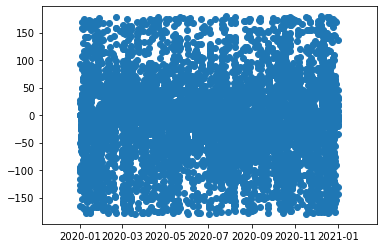

In [13]:
plt.scatter(full_flow_ds.valid_time,full_flow_ds.angle2)

In [14]:
angle = np.arctan(victas_flow_ds.v/victas_flow_ds.u)*180/np.pi
angle

<xarray.DataArray (valid_time: 8721)>
array([44.42152085, 80.33742973,         nan, ..., 46.49652796,
       37.22248007, 29.61793369])
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:00:00

In [32]:
full_flow_ds = victas_flow_ds.assign(angle2 = angle2)
full_flow_ds

<xarray.Dataset>
Dimensions:     (valid_time: 8721)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:00:00
Data variables:
    u           (valid_time) float64 -1.509 -0.6284 0.0 ... -13.21 0.004456
    v           (valid_time) float64 -1.479 -3.691 0.0 ... -10.04 0.002533
    angle2      (valid_time) float64 -135.6 -99.66 0.0 0.0 ... 46.5 -142.8 29.62
Attributes:
    title:    Mean u/v flow for tile 16

In [15]:
full_flow_ds = victas_flow_ds.assign(angle = angle)
full_flow_ds

<xarray.Dataset>
Dimensions:     (valid_time: 8721)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:00:00
Data variables:
    u           (valid_time) float64 -1.509 -0.6284 0.0 ... -13.21 0.004456
    v           (valid_time) float64 -1.479 -3.691 0.0 ... -10.04 0.002533
    angle       (valid_time) float64 44.42 80.34 nan nan ... 46.5 37.22 29.62
Attributes:
    title:    Mean u/v flow for tile 16

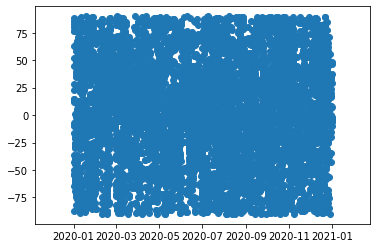

In [16]:
plt.scatter(full_flow_ds.valid_time,full_flow_ds.angle)

In [17]:
for num in range(len(full_flow_ds.valid_time)):
    if full_flow_ds.v[num] < 0 and full_flow_ds.u[num] < 0:
        full_flow_ds.angle[num] = full_flow_ds.angle[num] + 180

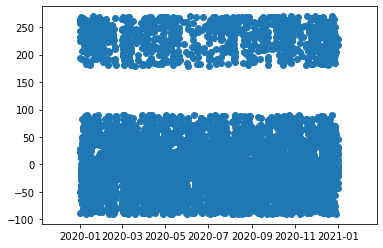

In [18]:
plt.scatter(full_flow_ds.valid_time,full_flow_ds.angle)

In [19]:
for num in range(len(full_flow_ds.valid_time)):
    if full_flow_ds.v[num] > 0 and full_flow_ds.u[num] < 0:
        full_flow_ds.angle[num] = full_flow_ds.angle[num] + 180

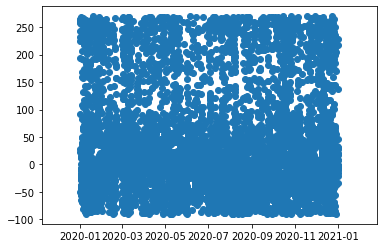

In [20]:
plt.scatter(full_flow_ds.valid_time,full_flow_ds.angle)

In [21]:
for num in range(len(full_flow_ds.valid_time)):
    if full_flow_ds.v[num] < 0 and full_flow_ds.u[num] > 0:
        full_flow_ds.angle[num] = full_flow_ds.angle[num] + 360

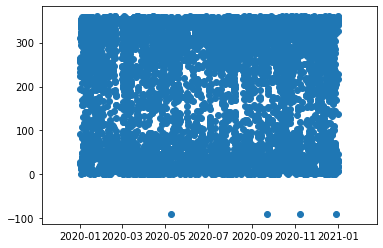

In [22]:
plt.scatter(full_flow_ds.valid_time,full_flow_ds.angle)

In [23]:
full_flow_ds.angle

<xarray.DataArray 'angle' (valid_time: 8721)>
array([224.42152085, 260.33742973,          nan, ...,  46.49652796,
       217.22248007,  29.61793369])
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:00:00

In [24]:
direction = np.linspace(0,0,num=len(full_flow_ds.valid_time))

In [43]:
for num in range(len(full_flow_ds.valid_time)):
    if full_flow_ds.angle2[num] >= 67.5 and full_flow_ds.angle2[num] <= 112.5:
        direction[num] = 1

In [44]:
for num in range(len(full_flow_ds.valid_time)):
    if full_flow_ds.angle2[num] >= 112.5 and full_flow_ds.angle2[num] <= 157.5:
        direction[num] = 2

In [45]:
for num in range(len(full_flow_ds.valid_time)):
    if full_flow_ds.angle2[num] >= 157.5:
        direction[num] = 3

In [46]:
for num in range(len(full_flow_ds.valid_time)):
    if full_flow_ds.angle2[num] <= -157.5:
        direction[num] = 3

In [47]:
for num in range(len(full_flow_ds.valid_time)):
    if full_flow_ds.angle2[num] >= -157.5 and full_flow_ds.angle2[num] <= -112.5:
        direction[num] = 4

In [48]:
for num in range(len(full_flow_ds.valid_time)):
    if full_flow_ds.angle2[num] >= -112.5 and full_flow_ds.angle2[num] <= -67.5:
        direction[num] = 5

In [49]:
for num in range(len(full_flow_ds.valid_time)):
    if full_flow_ds.angle2[num] >= -67.5 and full_flow_ds.angle2[num] <= -22.5:
        direction[num] = 6

In [50]:
for num in range(len(full_flow_ds.valid_time)):
    if full_flow_ds.angle2[num] >= -22.5 and full_flow_ds.angle2[num] <= 22.5:
        direction[num] = 7

In [51]:
for num in range(len(full_flow_ds.valid_time)):
    if full_flow_ds.angle2[num] >= 22.5 and full_flow_ds.angle2[num] <= 67.5:
        direction[num] = 8

In [52]:
direction

array([4., 5., 7., ..., 8., 4., 8.])

In [58]:
direction_da = xr.DataArray(direction,dims=["valid_time"],coords=dict(valid_time=victas_flow_ds.valid_time),name="direction_num")

In [59]:
full_flow_direction_ds = victas_flow_ds.assign(direction_num = direction_da)
full_flow_direction_ds

<xarray.Dataset>
Dimensions:        (valid_time: 8721)
Coordinates:
  * valid_time     (valid_time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:00:00
Data variables:
    u              (valid_time) float64 -1.509 -0.6284 0.0 ... -13.21 0.004456
    v              (valid_time) float64 -1.479 -3.691 0.0 ... -10.04 0.002533
    direction_num  (valid_time) float64 4.0 5.0 7.0 7.0 7.0 ... 7.0 8.0 4.0 8.0
Attributes:
    title:    Mean u/v flow for tile 16

In [54]:
full_flow_dem_ds = full_flow_direction_ds.assign(dem = topo_v.drop(['lat','lon']))
full_flow_dem_ds

<xarray.Dataset>
Dimensions:        (direction_num: 8721, valid_time: 8721, x: 512, y: 512)
Coordinates:
  * valid_time     (valid_time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:00:00
  * direction_num  (direction_num) float64 4.0 5.0 7.0 7.0 ... 7.0 8.0 4.0 8.0
  * x              (x) float64 6.89e+05 6.91e+05 ... 1.709e+06 1.711e+06
  * y              (y) float64 -4.911e+06 -4.909e+06 ... -3.891e+06 -3.889e+06
Data variables:
    u              (valid_time) float64 -1.509 -0.6284 0.0 ... -13.21 0.004456
    v              (valid_time) float64 -1.479 -3.691 0.0 ... -10.04 0.002533
    dem            (y, x) float32 nan nan nan nan ... 479.9012 205.0974 33.26088
Attributes:
    title:    Mean u/v flow for tile 16

In [55]:
full_flow_dem_ds.direction_num

<xarray.DataArray 'direction_num' (direction_num: 8721)>
array([4., 5., 7., ..., 8., 4., 8.])
Coordinates:
  * direction_num  (direction_num) float64 4.0 5.0 7.0 7.0 ... 7.0 8.0 4.0 8.0

In [56]:
# fig,ax=plt.subplots(figsize=(15,12),subplot_kw={'projection':target_proj_v})
# dem_plot = full_flow_dem_ds.direction_num.plot.contourf(levels=8,cmap='RdYlBu',add_colorbar=False,ax=ax,add_labels=True,alpha=0.8)
# freq_plot = (full_flow_dem_ds.u,full_flow_dem_ds.v).plot.contourf(levels=6,cmap='gist_heat_r',add_colorbar=False,ax=ax,add_labels=True,alpha=0.8)
# plt.colorbar(dem_plot, shrink=0.5)
# plt.colorbar(freq_plot, shrink=0.5)
# ax.coastlines('10m')
# ax.set_title('VicTas Precipitation Average - 2020')
# plt.show()

In [60]:
full_flow_direction_ds.to_netcdf('/home/565/dm2042/WIL/mean-flow/flow_direction_num_perth2.nc')